In [80]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

### Basics

In [24]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20", reset=True).index.max().strftime(format = "%Y-%m-%d")}')
    
    
def update_stocks_nc():
    os.system("rm mstncn.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/newconnect/mstock/mstncn.zip")
    #os.system("rm -rf data/*")
    os.system("unzip mstncn.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("CLOUD", reset=True).index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper, reset=False):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    if (paper in store_stocks_dict.keys()) & (reset==False):
        df = store_stocks_dict[paper].copy()
    else:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

### dates and special papers to monitor

In [17]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

watch = ['PZU','AMREST','KGHM', 'ASSECOSEE', 'NORTCOAST', 'CDPROJEKT', 
         'VOTUM', 'NEWAG', 'KRUSZWICA', 'INTERAOLT', 'PLAY', 'ARCHICOM', 'LPP', 'ARCTIC', 'PGNIG','TAURONPE', 
         'PKOBP', 'JSW','INTERCARS','BIOMEDLUB','PKOBP','PEKAO','SUNEX','INTERCARS','WIELTON']

watch_af = ['KGHM','KRUK', 'PKNORLEN',
            'ENEA','MBANK', 'PKOBP', 'WIELTON']

## Do updates

In [25]:
update_indexes()
update_stocks()
update_stocks_nc()

all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

Updated 2020-05-26, max actual date:     2020-05-25
Updated 2020-05-26, max actual date:     2020-05-25
Updated 2020-05-26, max actual date:     2020-05-25
no of all available stock: 2438 and indexes: 23


## Single plot

### Plot code

In [15]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [12]:
[a for a in all_stocks if 'INTROL' in a]

['INTROL.mst']

In [13]:
papier = 'INTROL'

In [14]:
#plot_paper(papier,'2008-07-15','2008-11-15')

/home/show/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


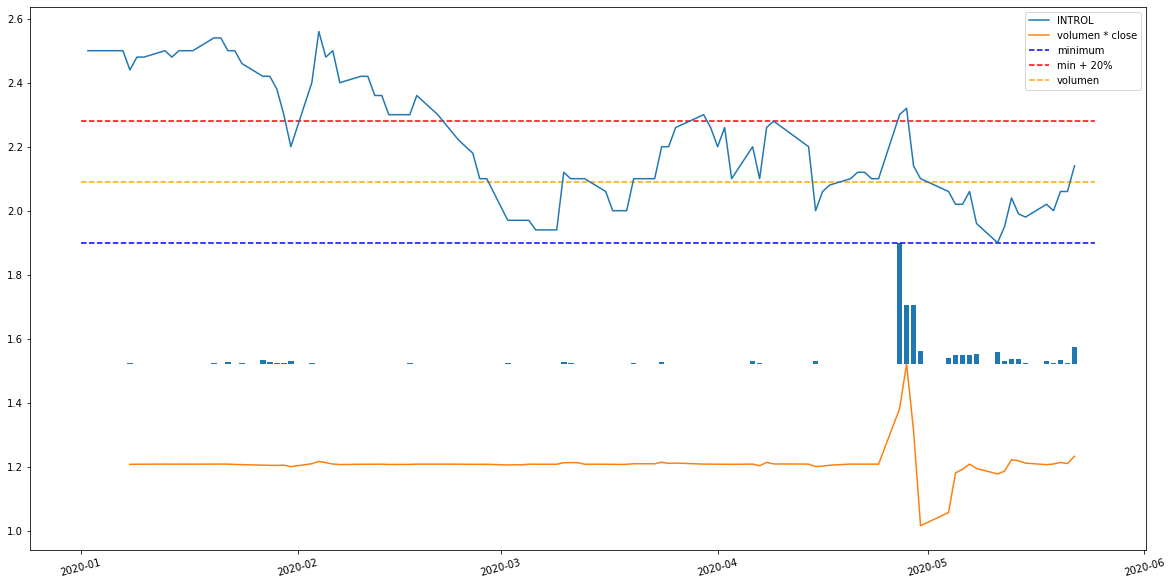

In [16]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [18]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: INTROL, currently at 2.14, with potential 19.63% to top
Max before crisis: 2.56
Crisis bottom: 1.94
Max after crisis drop: 2.32, at 2020-04-28 00:00:00
Stats after Max: [2.32 2.14 2.1  2.06 2.02 2.02 2.06 1.96 1.9  1.95 2.04 1.99 1.98 2.02
 2.   2.06 2.06 2.14]


## Skaner

In [38]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'mean_VOL', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [39]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index > '2019-10-01' ,'VOL'].mean(),
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('DVP' in x)
                               | ('RCT' in x)
                               | ('RCS' in x)
                               | ('RCR' in x)
                               | ('RCB' in x)
                               | ('PBSK' in x)
                               | ('RCL' in x) else True).values,]

100%|██████████| 2438/2438 [00:12<00:00, 202.56it/s]


In [40]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        #(skaner_df.growth_current > -100)
    (skaner_df.mean_VOL > 50000)
                              ,:].sort_values('drop_current', ascending=True)

print(skaner_df_see.dropna().shape)

skaner_df_see = skaner_df_see.dropna().copy()

(136, 15)


## Model

In [41]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5, 10, 20, 30, 60, 120, 240]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###

#     df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
#     df.loc[df.loc[:, 'max_5d'].shift(-5) > df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 1
#     df.loc[df.loc[:, 'max_5d'].shift(-5) <= df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 0
    
    df.loc[:, 'max_1d'] = df.loc[:, 'HIGH'].rolling(1).max()
    df.loc[df.loc[:, 'max_1d'].shift(-1) > df.loc[:, 'OPEN'].shift(-1)*1.03,'target'] = 1
    df.loc[df.loc[:, 'max_1d'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1)*1.03,'target'] = 0
    
    return df
#ADD INDEX MEANS!
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    
#     for b in ['chng_OPEN', 'chng_LOW', 'chng_HIGH', 'chng_CLOSE', 'chng_VOL']:    
#         for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
#             df.loc[:,f'idxroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
#             df.loc[:,f'idxroll{g}min_' + b] = df.loc[:,b].rolling(g).min()
#             df.loc[:,f'idxroll{g}max_' + b] = df.loc[:,b].rolling(g).max()
#             df.loc[:,f'idxroll{g}std_' + b] = df.loc[:,b].rolling(g).std()
    return df

In [42]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [43]:
q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.dropna().ticker.values))
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
#p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

 98%|█████████▊| 143/146 [03:08<00:03,  1.32s/it]


In [44]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

 99%|█████████▉| 143/144 [00:05<00:00, 26.62it/s]


In [45]:
df_papers = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_papers = pd.concat([df_papers , df])
    pbar.update(1)
pbar.close()

100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


In [46]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

42

In [47]:
df_indexes = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes = pd.concat([df_indexes, df])
    del df

100%|██████████| 23/23 [00:01<00:00, 20.20it/s]


In [48]:
df_indexes = df_indexes.reset_index().groupby('DTYYYYMMDD')[['OPEN', 'HIGH', 'CLOSE']].agg(['mean', 'max', 'std']).dropna(how = 'all',axis = 1)
df_indexes.columns = 'foreign_stocks_' + df_indexes.columns.get_level_values(1) + '_chng_' + df_indexes.columns.get_level_values(0)
df_indexes = df_indexes.dropna(how = 'all',axis = 1)

In [49]:
df_merged = df_papers.merge(df_indexes, left_index=True, right_index=True, how = 'left')

train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

In [50]:
valid = df_merged.loc[df_merged.index >= '2020-04-01'].copy()

df_merged = df_merged.loc[df_merged.index < '2020-04-01']

cut_date = '2019-11-01'
train_data = df_merged.loc[df_merged.index < cut_date,train_cols]
eval_data = df_merged.loc[df_merged.index >= cut_date,train_cols]
train_labels = df_merged.loc[df_merged.index < cut_date,'target'].values
eval_labels = df_merged.loc[df_merged.index >= cut_date,'target'].values

In [51]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.02,
                               #bagging_temperature=3,
                               #random_strength = 3,
                               use_best_model=True,
                               min_data_in_leaf=200,
                               #sampling_frequency=1,
                               #subsample = 0.8,
                           depth=5,
                               has_time=True,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='CPU')
    return model

### Train

In [52]:
model = get_model()

model.fit(train_data, train_labels, #cat_features=[0, 1],
          #eval_set=[(train_data[:-1], train_labels[:-1]),(eval_data[:-1], eval_labels[:-1])],
          eval_set=[(eval_data, eval_labels)],
         early_stopping_rounds=100, use_best_model=True)

0:	test: 0.7515308	best: 0.7515308 (0)	total: 287ms	remaining: 47m 54s
1:	test: 0.7781106	best: 0.7781106 (1)	total: 487ms	remaining: 40m 35s
2:	test: 0.7788063	best: 0.7788063 (2)	total: 713ms	remaining: 39m 37s
3:	test: 0.7793849	best: 0.7793849 (3)	total: 1s	remaining: 41m 49s
4:	test: 0.7810049	best: 0.7810049 (4)	total: 1.31s	remaining: 43m 31s
5:	test: 0.7824223	best: 0.7824223 (5)	total: 1.57s	remaining: 43m 44s
6:	test: 0.7848617	best: 0.7848617 (6)	total: 1.84s	remaining: 43m 55s
7:	test: 0.7846533	best: 0.7848617 (6)	total: 2.14s	remaining: 44m 37s
8:	test: 0.7866195	best: 0.7866195 (8)	total: 2.44s	remaining: 45m 4s
9:	test: 0.7862107	best: 0.7866195 (8)	total: 2.73s	remaining: 45m 30s
10:	test: 0.7884922	best: 0.7884922 (10)	total: 2.93s	remaining: 44m 22s
11:	test: 0.7891118	best: 0.7891118 (11)	total: 3.14s	remaining: 43m 33s
12:	test: 0.7891932	best: 0.7891932 (12)	total: 3.33s	remaining: 42m 41s
13:	test: 0.7896475	best: 0.7896475 (13)	total: 3.55s	remaining: 42m 10s
14

114:	test: 0.7950766	best: 0.7950766 (114)	total: 29.9s	remaining: 42m 46s
115:	test: 0.7950868	best: 0.7950868 (115)	total: 30.1s	remaining: 42m 48s
116:	test: 0.7951008	best: 0.7951008 (116)	total: 30.4s	remaining: 42m 50s
117:	test: 0.7951383	best: 0.7951383 (117)	total: 30.7s	remaining: 42m 52s
118:	test: 0.7951534	best: 0.7951534 (118)	total: 31s	remaining: 42m 57s
119:	test: 0.7951915	best: 0.7951915 (119)	total: 31.3s	remaining: 42m 55s
120:	test: 0.7952019	best: 0.7952019 (120)	total: 31.5s	remaining: 42m 54s
121:	test: 0.7952132	best: 0.7952132 (121)	total: 31.8s	remaining: 42m 54s
122:	test: 0.7952003	best: 0.7952132 (121)	total: 32s	remaining: 42m 52s
123:	test: 0.7952202	best: 0.7952202 (123)	total: 32.3s	remaining: 42m 51s
124:	test: 0.7952588	best: 0.7952588 (124)	total: 32.5s	remaining: 42m 48s
125:	test: 0.7952297	best: 0.7952588 (124)	total: 32.8s	remaining: 42m 47s
126:	test: 0.7952774	best: 0.7952774 (126)	total: 33s	remaining: 42m 43s
127:	test: 0.7952916	best: 0.79

225:	test: 0.7959874	best: 0.7959874 (225)	total: 56.4s	remaining: 40m 40s
226:	test: 0.7959944	best: 0.7959944 (226)	total: 56.6s	remaining: 40m 38s
227:	test: 0.7960226	best: 0.7960226 (227)	total: 56.8s	remaining: 40m 35s
228:	test: 0.7960308	best: 0.7960308 (228)	total: 57.1s	remaining: 40m 35s
229:	test: 0.7960493	best: 0.7960493 (229)	total: 57.4s	remaining: 40m 39s
230:	test: 0.7960613	best: 0.7960613 (230)	total: 57.7s	remaining: 40m 40s
231:	test: 0.7960589	best: 0.7960613 (230)	total: 58.1s	remaining: 40m 44s
232:	test: 0.7960545	best: 0.7960613 (230)	total: 58.3s	remaining: 40m 44s
233:	test: 0.7960577	best: 0.7960613 (230)	total: 58.6s	remaining: 40m 44s
234:	test: 0.7960791	best: 0.7960791 (234)	total: 58.8s	remaining: 40m 41s
235:	test: 0.7960865	best: 0.7960865 (235)	total: 59s	remaining: 40m 42s
236:	test: 0.7960953	best: 0.7960953 (236)	total: 59.3s	remaining: 40m 41s
237:	test: 0.7961142	best: 0.7961142 (237)	total: 59.6s	remaining: 40m 44s
238:	test: 0.7961253	best: 

334:	test: 0.7963597	best: 0.7963833 (328)	total: 1m 25s	remaining: 40m 53s
335:	test: 0.7963565	best: 0.7963833 (328)	total: 1m 25s	remaining: 40m 52s
336:	test: 0.7963582	best: 0.7963833 (328)	total: 1m 25s	remaining: 40m 51s
337:	test: 0.7963748	best: 0.7963833 (328)	total: 1m 25s	remaining: 40m 50s
338:	test: 0.7963767	best: 0.7963833 (328)	total: 1m 26s	remaining: 40m 50s
339:	test: 0.7963837	best: 0.7963837 (339)	total: 1m 26s	remaining: 40m 50s
340:	test: 0.7963724	best: 0.7963837 (339)	total: 1m 26s	remaining: 40m 49s
341:	test: 0.7963827	best: 0.7963837 (339)	total: 1m 26s	remaining: 40m 49s
342:	test: 0.7963887	best: 0.7963887 (342)	total: 1m 26s	remaining: 40m 48s
343:	test: 0.7963975	best: 0.7963975 (343)	total: 1m 27s	remaining: 40m 48s
344:	test: 0.7963928	best: 0.7963975 (343)	total: 1m 27s	remaining: 40m 48s
345:	test: 0.7964106	best: 0.7964106 (345)	total: 1m 27s	remaining: 40m 48s
346:	test: 0.7963992	best: 0.7964106 (345)	total: 1m 28s	remaining: 40m 49s
347:	test: 0

443:	test: 0.7967816	best: 0.7967816 (443)	total: 1m 56s	remaining: 41m 38s
444:	test: 0.7967880	best: 0.7967880 (444)	total: 1m 56s	remaining: 41m 40s
445:	test: 0.7967783	best: 0.7967880 (444)	total: 1m 56s	remaining: 41m 40s
446:	test: 0.7967812	best: 0.7967880 (444)	total: 1m 57s	remaining: 41m 41s
447:	test: 0.7967905	best: 0.7967905 (447)	total: 1m 57s	remaining: 41m 42s
448:	test: 0.7968031	best: 0.7968031 (448)	total: 1m 57s	remaining: 41m 41s
449:	test: 0.7968080	best: 0.7968080 (449)	total: 1m 57s	remaining: 41m 42s
450:	test: 0.7968020	best: 0.7968080 (449)	total: 1m 58s	remaining: 41m 44s
451:	test: 0.7967862	best: 0.7968080 (449)	total: 1m 58s	remaining: 41m 47s
452:	test: 0.7967899	best: 0.7968080 (449)	total: 1m 58s	remaining: 41m 46s
453:	test: 0.7967798	best: 0.7968080 (449)	total: 1m 59s	remaining: 41m 46s
454:	test: 0.7967843	best: 0.7968080 (449)	total: 1m 59s	remaining: 41m 47s
455:	test: 0.7967871	best: 0.7968080 (449)	total: 1m 59s	remaining: 41m 50s
456:	test: 0

552:	test: 0.7969869	best: 0.7969957 (546)	total: 2m 29s	remaining: 42m 26s
553:	test: 0.7970057	best: 0.7970057 (553)	total: 2m 29s	remaining: 42m 27s
554:	test: 0.7970031	best: 0.7970057 (553)	total: 2m 29s	remaining: 42m 26s
555:	test: 0.7970098	best: 0.7970098 (555)	total: 2m 29s	remaining: 42m 27s
556:	test: 0.7969855	best: 0.7970098 (555)	total: 2m 30s	remaining: 42m 28s
557:	test: 0.7970013	best: 0.7970098 (555)	total: 2m 30s	remaining: 42m 28s
558:	test: 0.7970202	best: 0.7970202 (558)	total: 2m 30s	remaining: 42m 28s
559:	test: 0.7970437	best: 0.7970437 (559)	total: 2m 31s	remaining: 42m 29s
560:	test: 0.7970442	best: 0.7970442 (560)	total: 2m 31s	remaining: 42m 28s
561:	test: 0.7970408	best: 0.7970442 (560)	total: 2m 31s	remaining: 42m 28s
562:	test: 0.7970606	best: 0.7970606 (562)	total: 2m 32s	remaining: 42m 28s
563:	test: 0.7970650	best: 0.7970650 (563)	total: 2m 32s	remaining: 42m 30s
564:	test: 0.7970712	best: 0.7970712 (564)	total: 2m 32s	remaining: 42m 30s
565:	test: 0

660:	test: 0.7972948	best: 0.7973177 (654)	total: 3m	remaining: 42m 33s
661:	test: 0.7972995	best: 0.7973177 (654)	total: 3m	remaining: 42m 32s
662:	test: 0.7972994	best: 0.7973177 (654)	total: 3m 1s	remaining: 42m 35s
663:	test: 0.7973071	best: 0.7973177 (654)	total: 3m 1s	remaining: 42m 35s
664:	test: 0.7973076	best: 0.7973177 (654)	total: 3m 2s	remaining: 42m 35s
665:	test: 0.7972989	best: 0.7973177 (654)	total: 3m 2s	remaining: 42m 35s
666:	test: 0.7972889	best: 0.7973177 (654)	total: 3m 2s	remaining: 42m 34s
667:	test: 0.7972883	best: 0.7973177 (654)	total: 3m 2s	remaining: 42m 34s
668:	test: 0.7972947	best: 0.7973177 (654)	total: 3m 3s	remaining: 42m 35s
669:	test: 0.7972815	best: 0.7973177 (654)	total: 3m 3s	remaining: 42m 35s
670:	test: 0.7972876	best: 0.7973177 (654)	total: 3m 3s	remaining: 42m 35s
671:	test: 0.7972972	best: 0.7973177 (654)	total: 3m 4s	remaining: 42m 35s
672:	test: 0.7972928	best: 0.7973177 (654)	total: 3m 4s	remaining: 42m 34s
673:	test: 0.7972924	best: 0.79

769:	test: 0.7975148	best: 0.7975148 (769)	total: 3m 33s	remaining: 42m 38s
770:	test: 0.7975084	best: 0.7975148 (769)	total: 3m 33s	remaining: 42m 38s
771:	test: 0.7975054	best: 0.7975148 (769)	total: 3m 34s	remaining: 42m 39s
772:	test: 0.7975014	best: 0.7975148 (769)	total: 3m 34s	remaining: 42m 39s
773:	test: 0.7975015	best: 0.7975148 (769)	total: 3m 34s	remaining: 42m 39s
774:	test: 0.7975007	best: 0.7975148 (769)	total: 3m 34s	remaining: 42m 38s
775:	test: 0.7975137	best: 0.7975148 (769)	total: 3m 35s	remaining: 42m 38s
776:	test: 0.7975244	best: 0.7975244 (776)	total: 3m 35s	remaining: 42m 37s
777:	test: 0.7975172	best: 0.7975244 (776)	total: 3m 35s	remaining: 42m 38s
778:	test: 0.7975241	best: 0.7975244 (776)	total: 3m 36s	remaining: 42m 37s
779:	test: 0.7975035	best: 0.7975244 (776)	total: 3m 36s	remaining: 42m 37s
780:	test: 0.7975164	best: 0.7975244 (776)	total: 3m 36s	remaining: 42m 38s
781:	test: 0.7975102	best: 0.7975244 (776)	total: 3m 37s	remaining: 42m 39s
782:	test: 0

878:	test: 0.7973630	best: 0.7975565 (794)	total: 4m 5s	remaining: 42m 27s
879:	test: 0.7973592	best: 0.7975565 (794)	total: 4m 5s	remaining: 42m 27s
880:	test: 0.7973675	best: 0.7975565 (794)	total: 4m 6s	remaining: 42m 27s
881:	test: 0.7973488	best: 0.7975565 (794)	total: 4m 6s	remaining: 42m 27s
882:	test: 0.7973732	best: 0.7975565 (794)	total: 4m 6s	remaining: 42m 27s
883:	test: 0.7973726	best: 0.7975565 (794)	total: 4m 7s	remaining: 42m 28s
884:	test: 0.7973715	best: 0.7975565 (794)	total: 4m 7s	remaining: 42m 29s
885:	test: 0.7973686	best: 0.7975565 (794)	total: 4m 7s	remaining: 42m 29s
886:	test: 0.7973414	best: 0.7975565 (794)	total: 4m 8s	remaining: 42m 29s
887:	test: 0.7973327	best: 0.7975565 (794)	total: 4m 8s	remaining: 42m 29s
888:	test: 0.7973630	best: 0.7975565 (794)	total: 4m 8s	remaining: 42m 28s
889:	test: 0.7973513	best: 0.7975565 (794)	total: 4m 8s	remaining: 42m 28s
890:	test: 0.7973595	best: 0.7975565 (794)	total: 4m 9s	remaining: 42m 28s
891:	test: 0.7973570	best

In [53]:
model.get_feature_importance(prettified=True).head(12)

,Feature Id,Importances
0,roll240std_diff_LOW_CLOSE,3.939402
1,roll80std_diff_LOW_CLOSE,3.483820
2,diff_LOW_HIGH,3.003385
3,roll40std_diff_LOW_HIGH,2.976929
4,roll80max_diff_LOW_HIGH,2.709240
5,roll240max_diff_LOW_CLOSE,2.621208
6,roll40max_diff_LOW_HIGH,2.389835
7,roll10m_diff_LOW_HIGH,1.953395
8,roll10max_diff_LOW_HIGH,1.928570
9,roll20max_diff_LOW_HIGH,1.808518


In [54]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

155

### Check eval

In [55]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [56]:
preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [57]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(7760, 546, 1950, 903)

In [58]:
(tn + tp) / (tn + tp + fp + fn)

0.7763240433730622

In [59]:
tp / (tp + fp)

0.6231884057971014

In [60]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.804843,0.195157
1.0,0.600269,0.399731


In [61]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)
df_res_grouped = df_res.drop('zero', axis = 1)

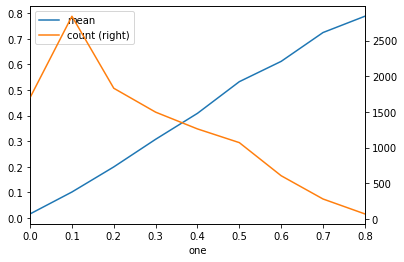

In [62]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [63]:
df_res_grouped

,mean,count
one,,
0.0,0.015285,1701
0.1,0.101021,2841
0.2,0.199236,1832
0.3,0.307281,1497
0.4,0.408875,1262
0.5,0.532710,1070
0.6,0.612211,606
0.7,0.725000,280
0.8,0.788732,71


### Check valid

In [64]:
valid_data = valid.loc[:,train_cols]
valid_labels = valid.loc[:,'target'].values

preds_class = model.predict(valid_data)
# Get predicted probabilities for each class

preds = preds_class[:-1].astype(int)

In [65]:
preds_proba = model.predict_proba(valid_data)

preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [66]:
tn, fp, fn, tp = confusion_matrix(valid_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(2586, 204, 955, 275)

In [67]:
(tn + tp) / (tn + tp + fp + fn)

0.7116915422885572

In [68]:
tp / (tp + fp)

0.5741127348643006

In [72]:
(tp / preds.shape[0]) * 100

6.8407960199004965

### Prediction

In [73]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes,
              left_index=True,
              right_index=True,
              how='left')

        #df.loc[:, 'pred_class'] = model.predict(df[train_cols])
        df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fut5_CLOSE'] = df.loc[:, 'CLOSE'].shift(-5)
        df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
        
        df.loc[:, 'fut10_CLOSE'] = df.loc[:, 'CLOSE'].shift(-10)
        df.loc[:, 'max_10d'] = df.loc[:, 'CLOSE'].rolling(10).max()
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
        
        df.loc[:, 'fOPEN_f10CLOSE_chng'] = (df.loc[:, 'fut10_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f10MAX_chng'] = (df.loc[:, 'max_10d'].shift(-10) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5CLOSE_chng'] = (df.loc[:, 'fut5_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5MAX_chng'] = (df.loc[:, 'max_5d'].shift(-5) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE', 'fOPEN_fHIGH_chng', 
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 
            'fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng',
            'fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng', 'pred_prob']
                                      ].tail(30)
    
        #if one_res.shape == (15, 16):
        qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [74]:
qpapers = Queue()
qtransformed = Queue()

for w in (skaner_df_see.dropna().ticker.values):
    qpapers.put(w)

total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
#p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


pbar = tqdm(total = total)

while not qpapers.empty():
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()

 97%|█████████▋| 132/136 [02:55<00:05,  1.33s/it]


In [75]:
qtransformed.qsize()

136

In [76]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)

100%|██████████| 136/136 [00:00<00:00, 674.85it/s]


In [77]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

### Prediction results

In [78]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)

In [79]:
res.loc[res.DTYYYYMMDD == prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")]\
.sort_values('pred_prob', ascending=False).dropna(how='all', axis = 1).head(15)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,pred_prob
1620,2020-05-25,TELGAM,0.390,0.390,0.478,0.478,0.767507
1079,2020-05-25,SOFTBLUE,1.650,1.550,2.000,1.980,0.756515
1882,2020-05-25,MBFGROUP,4.020,3.700,4.160,3.800,0.716367
408,2020-05-25,HORNIGOLD,0.190,0.154,0.190,0.180,0.597201
3025,2020-05-25,TRAKCJA,1.804,1.802,2.050,2.045,0.583396
2968,2020-05-25,POZBUD,1.220,1.210,1.380,1.350,0.582028
1322,2020-05-25,AIRWAY,0.598,0.586,0.770,0.738,0.559970
865,2020-05-25,JWA,0.288,0.270,0.329,0.328,0.556694
2216,2020-05-25,LIBET,1.880,1.850,2.000,1.975,0.553287
2168,2020-05-25,COLUMBUS,23.700,23.450,26.200,25.900,0.552522


In [104]:
last_day = res.loc[res.DTYYYYMMDD == (prepare_data("WIG20").reset_index()['DTYYYYMMDD']).nlargest(2).iloc[1].strftime(format = "%Y-%m-%d")].sort_values('pred_prob', ascending=False)

In [105]:
last_day.mean().dropna()

OPEN                 1358.849663
LOW                  1351.531550
HIGH                 1365.548305
CLOSE                1361.451658
fut_OPEN             1392.690420
fut_LOW              1388.425668
fut_HIGH             1404.269481
fut_CLOSE            1400.235527
fOPEN_fHIGH_chng        3.032027
fOPEN_fCLOSE_chng       1.452331
CLOSE_fOPEN_chng        0.693283
HIGH_fHIGH_chng         1.364642
LOW_fLOW_chng           1.069945
pred_prob               0.255931
dtype: float64

In [107]:
last_day.loc[last_day.pred_prob > 0.5].mean().dropna()

OPEN                 4.880643
LOW                  4.752786
HIGH                 5.278286
CLOSE                5.168786
fut_OPEN             5.222714
fut_LOW              4.917429
fut_HIGH             5.417643
fut_CLOSE            5.173214
fOPEN_fHIGH_chng     5.917000
fOPEN_fCLOSE_chng    2.966943
CLOSE_fOPEN_chng     2.035475
HIGH_fHIGH_chng      1.873349
LOW_fLOW_chng        2.718772
pred_prob            0.573640
dtype: float64

In [111]:
last_day.loc[(last_day.pred_prob > 0.5) & 
            (last_day.CLOSE_fOPEN_chng >=0),:].mean()

OPEN                   5.099900
LOW                    5.020000
HIGH                   5.537900
CLOSE                  5.477300
fut_OPEN               5.590000
fut_LOW                5.233000
fut_HIGH               5.714200
fut_CLOSE              5.444500
fOPEN_fHIGH_chng       5.962383
fOPEN_fCLOSE_chng      4.046357
CLOSE_fOPEN_chng       3.619091
HIGH_fHIGH_chng        3.773193
LOW_fLOW_chng          3.774330
fOPEN_f5CLOSE_chng          NaN
fOPEN_f5MAX_chng            NaN
fOPEN_f10CLOSE_chng         NaN
fOPEN_f10MAX_chng           NaN
pred_prob              0.568205
dtype: float64

In [112]:
last_day.loc[(last_day.pred_prob > 0.5) & 
            (last_day.CLOSE_fOPEN_chng <0),:].mean()

OPEN                   4.332500
LOW                    4.084750
HIGH                   4.629250
CLOSE                  4.397500
fut_OPEN               4.304500
fut_LOW                4.128500
fut_HIGH               4.676250
fut_CLOSE              4.495000
fOPEN_fHIGH_chng       5.803542
fOPEN_fCLOSE_chng      0.268409
CLOSE_fOPEN_chng      -1.923565
HIGH_fHIGH_chng       -2.876258
LOW_fLOW_chng          0.079876
fOPEN_f5CLOSE_chng          NaN
fOPEN_f5MAX_chng            NaN
fOPEN_f10CLOSE_chng         NaN
fOPEN_f10MAX_chng           NaN
pred_prob              0.587226
dtype: float64

In [113]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()

In [114]:
res_see.groupby('DTYYYYMMDD').mean().mean()

OPEN                   538.454744
LOW                    532.893670
HIGH                   543.414755
CLOSE                  538.409381
fut_OPEN               528.729979
fut_LOW                523.307136
fut_HIGH               533.568564
fut_CLOSE              528.596806
fOPEN_fHIGH_chng         6.237442
fOPEN_fCLOSE_chng        1.509196
CLOSE_fOPEN_chng        -0.376604
HIGH_fHIGH_chng          0.963068
LOW_fLOW_chng            1.595210
fOPEN_f5CLOSE_chng       8.249199
fOPEN_f5MAX_chng        20.343130
fOPEN_f10CLOSE_chng     17.870305
fOPEN_f10MAX_chng       45.611003
pred_prob                0.391886
dtype: float64

In [115]:
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()

OPEN                    3.420665
LOW                     3.181973
HIGH                    3.688649
CLOSE                   3.428920
fut_OPEN                3.465475
fut_LOW                 3.246413
fut_HIGH                3.689199
fut_CLOSE               3.460204
fOPEN_fHIGH_chng        9.591618
fOPEN_fCLOSE_chng       1.109308
CLOSE_fOPEN_chng        0.360635
HIGH_fHIGH_chng         0.269087
LOW_fLOW_chng           3.225773
fOPEN_f5CLOSE_chng      6.374286
fOPEN_f5MAX_chng       21.453651
fOPEN_f10CLOSE_chng    13.394313
fOPEN_f10MAX_chng      44.359671
pred_prob               0.610202
dtype: float64

In [117]:
res_see.loc[(res_see.CLOSE_fOPEN_chng < 0) & 
           (res_see.pred_prob > 0.5)].groupby('DTYYYYMMDD').mean().mean()

OPEN                    3.812532
LOW                     3.511839
HIGH                    4.107870
CLOSE                   3.784399
fut_OPEN                3.664776
fut_LOW                 3.420128
fut_HIGH                3.943494
fut_CLOSE               3.667129
fOPEN_fHIGH_chng       10.363663
fOPEN_fCLOSE_chng       1.832599
CLOSE_fOPEN_chng       -7.928678
HIGH_fHIGH_chng        -7.232512
LOW_fLOW_chng          -5.534478
fOPEN_f5CLOSE_chng      5.367329
fOPEN_f5MAX_chng       18.298235
fOPEN_f10CLOSE_chng    12.240311
fOPEN_f10MAX_chng      41.127630
pred_prob               0.620487
dtype: float64

In [118]:
res_see.loc[(res_see.CLOSE_fOPEN_chng > 0) & 
           (res_see.pred_prob > 0.5)].groupby('DTYYYYMMDD').mean().mean()

OPEN                    4.158514
LOW                     3.896644
HIGH                    4.502565
CLOSE                   4.214111
fut_OPEN                4.348139
fut_LOW                 4.086704
fut_HIGH                4.614514
fut_CLOSE               4.353120
fOPEN_fHIGH_chng        8.222952
fOPEN_fCLOSE_chng       0.837927
CLOSE_fOPEN_chng        6.896756
HIGH_fHIGH_chng         6.207089
LOW_fLOW_chng           9.909425
fOPEN_f5CLOSE_chng      3.205876
fOPEN_f5MAX_chng       18.031622
fOPEN_f10CLOSE_chng     8.223641
fOPEN_f10MAX_chng      35.552978
pred_prob               0.608257
dtype: float64

## Reports

### Extract raw reports

In [174]:
reports_names = os.listdir('reports/')

In [178]:
one_rep  = pd.read_html('reports/' + reports_names[0])

In [182]:
one_rep[1].shape

(19, 39)

In [194]:
%%time
cols_extended = list()
col_counter = dict()
df_reports = pd.DataFrame()
for r in (reports_names):
    try:
        one_rep  = pd.read_html('reports/' + r)
    except Exception:
        print(r + ' Didnt go through!')
        continue
    for i in range(len(one_rep)):
        if (one_rep[i].shape[1] > 8):
            one_rep = one_rep[i]
            one_rep.columns = ['col_name'] + list(one_rep.columns[1:])
            one_rep = one_rep.set_index('col_name').transpose().reset_index()
            one_rep.loc[:, 'name'] = r
            print(one_rep.columns)
            df_reports = pd.concat([df_reports, one_rep], sort=False, axis = 0)
            if 'name' not in df_reports.columns:
                print('name not in the columns')
            #print(one_rep.columns)
            cols_extended.append(one_rep.columns)
            for c in one_rep.columns:
                if c in col_counter.keys():
                    col_counter[c] = col_counter[c] + 1
                else:
                    col_counter[c] = 0
            break

Index(['index', 'Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Koszty finansowe',
       'Pozostałe przychody (koszty)', 'Zysk z działalności gospodarczej',
       'Wynik zdarzeń nadzwyczajnych', 'Zysk przed opodatkowaniem',
       'Zysk (strata) netto z działalności zaniechanej', 'Zysk netto',
       'Zysk netto akcjonariuszy jednostki dominującej', 'EBITDA', 'name'],
      dtype='object', name='col_name')
Index(['index', 'Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Ko

ValueError: Plan shapes are not aligned

In [195]:
one_rep.head(2)

col_name,index,Data publikacji,Przychody odsetkowe,Przychody odsetkowe,Koszty odsetkowe,Wynik z tytułu odsetek,Przychody prowizyjne,Koszty prowizyjne,Wynik z tytułu prowizji,Przychody z tytułu dywidend,...,Ogólne koszty administracyjne,Pozostałe koszty operacyjne,Wynik operacyjny,Udział w zyskach jednostek podporządkowanych,Zysk przed opodatkowaniem,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,EBITDA,name
0,2015/Q1 (mar 15),2015-05-07,191 425,191 425,116 954,74 471,134 432,21 084,113 348,0,...,-129 333,-4 463,62 724,1 187,63 911,0,63 133,63 023,74 296,"raporty-IDEA-BANK,Q.html"
1,2015/Q2 (cze 15),2015-07-29,177 425k/k -7.31%~sektor -4.26%,177 425k/k -7.31%~sektor -4.26%,104 545k/k -10.61%~sektor -9.24%,72 880k/k -2.14%~sektor +3.65%,158 776k/k +18.11%~sektor +4.29%,31 145k/k +47.72%~sektor +5.86%,127 631k/k +12.60%~sektor +6.80%,0,...,-133 861k/k -3.50%~sektor -3.31%,-12 654k/k -183.53%~sektor -51.52%,66 041k/k +5.29%~sektor -1.39%,5 276k/k +344.48%~sektor +102.88%,71 317k/k +11.59%~sektor -1.57%,0,117 957k/k +86.84%~sektor +1.64%,117 917k/k +87.10%~sektor -0.83%,77 688k/k +4.57%~sektor -1.10%,"raporty-IDEA-BANK,Q.html"


In [196]:
 df_reports.head(2)

col_name,index,Data publikacji,Przychody ze sprzedaży,Techniczny koszt wytworzenia produkcji sprzedanej,Koszty sprzedaży,Koszty ogólnego zarządu,Zysk ze sprzedaży,Pozostałe przychody operacyjne,Pozostałe koszty operacyjne,Zysk operacyjny (EBIT),...,Koszty finansowe,Pozostałe przychody (koszty),Zysk z działalności gospodarczej,Wynik zdarzeń nadzwyczajnych,Zysk przed opodatkowaniem,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,EBITDA,name
0,2011/Q1 (mar 11),NaN,282 089,236 690,16 740,11 945,16 714,1 327,252,17 789,...,11 684,249,7 290,0,7 290,0,6 681,6 681,30 239,"raporty-ROKITA,Q.html"
1,2011/Q2 (cze 11),2011-08-31,120 180k/k -57.40%~sektor -6.11%,104 329k/k -55.92%~sektor -7.29%,7 965k/k -52.42%~sektor +8.14%,4 317k/k -63.86%~sektor +6.42%,3 569k/k -78.65%~sektor -16.66%,3 543k/k +166.99%~sektor +147.69%,15k/k -94.05%~sektor -21.72%,7 097k/k -60.10%~sektor -22.39%,...,-220k/k -101.88%~sektor -10.86%,-126k/k -150.60%~sektor -70.53%,7 391k/k +1.39%~sektor +1.39%,0,7 391k/k +1.39%~sektor +1.39%,2 033,9 276k/k +38.84%~sektor +2.49%,9 276k/k +38.84%~sektor -8.81%,20 119k/k -33.47%~sektor -15.70%,"raporty-ROKITA,Q.html"


In [197]:
test_cols = [c for c in one_rep if c in df_reports.columns]

In [198]:
test_cols

['index',
 'Data publikacji',
 'Pozostałe przychody operacyjne',
 'Pozostałe koszty operacyjne',
 'Zysk przed opodatkowaniem',
 'Zysk (strata) netto z działalności zaniechanej',
 'Zysk netto',
 'Zysk netto akcjonariuszy jednostki dominującej',
 'EBITDA',
 'name']

In [201]:
pd.concat([df_reports, one_rep[test_cols]], sort=True).head(2)

,Data publikacji,EBITDA,Koszty finansowe,Koszty ogólnego zarządu,Koszty sprzedaży,Pozostałe koszty operacyjne,Pozostałe przychody (koszty),Pozostałe przychody operacyjne,Przychody finansowe,Przychody ze sprzedaży,...,Wynik zdarzeń nadzwyczajnych,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,Zysk operacyjny (EBIT),Zysk przed opodatkowaniem,Zysk z działalności gospodarczej,Zysk ze sprzedaży,index,name
0,NaN,30 239,11 684,11 945,16 740,252,249,1 327,936,282 089,...,0,0,6 681,6 681,17 789,7 290,7 290,16 714,2011/Q1 (mar 11),"raporty-ROKITA,Q.html"
1,2011-08-31,20 119k/k -33.47%~sektor -15.70%,-220k/k -101.88%~sektor -10.86%,4 317k/k -63.86%~sektor +6.42%,7 965k/k -52.42%~sektor +8.14%,15k/k -94.05%~sektor -21.72%,-126k/k -150.60%~sektor -70.53%,3 543k/k +166.99%~sektor +147.69%,200k/k -78.63%~sektor -60.23%,120 180k/k -57.40%~sektor -6.11%,...,0,2 033,9 276k/k +38.84%~sektor +2.49%,9 276k/k +38.84%~sektor -8.81%,7 097k/k -60.10%~sektor -22.39%,7 391k/k +1.39%~sektor +1.39%,7 391k/k +1.39%~sektor +1.39%,3 569k/k -78.65%~sektor -16.66%,2011/Q2 (cze 11),"raporty-ROKITA,Q.html"


### Analyze

In [170]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN


## Bossa fin reports

In [82]:
one_report = pd.read_html('fin_reports_bossa/20kwart1.txt')

ImportError: BeautifulSoup4 (bs4) not found, please install it